In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_market_calendars as mcal
import datetime as dt
import scipy as sp

import pymc3 as pm
from theano import tensor as tt
from theano import shared
import arviz as az
import seaborn as sns
az.style.use("arviz-darkgrid")

import os
import sys


from jupyterthemes import jtplot
jtplot.style(theme="monokai")

# Multivariate Student T Model

This model assumes that the asset returns have a multivariate student t distribution (so constant volatility). Key components that are inferred are the covariance matrix and vector of mean returns.

# data_processing.py
This is similar to in the markowitz model

In [2]:
os.chdir(sys.path[0]+"/raw_data")
os.listdir()

# Read in files and grab daily close prices
df = pd.DataFrame(data={"returns"})
for n, fname in enumerate(os.listdir()):
    if n == 0:
        ticker = fname.split(".csv")[0]
        df = pd.read_csv(fname, index_col="Date", parse_dates=True)[["Adj Close"]].rename(columns={"Adj Close" : ticker})
    else:
        ticker = fname.split(".csv")[0]
        temp_df = pd.read_csv(fname, index_col="Date", parse_dates=True)[["Adj Close"]].rename(columns={"Adj Close" : ticker})
        df = pd.merge(df, temp_df, left_index=True, right_index=True)

In [3]:
# Convert to daily log returns
df = np.log(df) - np.log(df.shift(1))
df = df.dropna()

In [4]:
# Input to model is each of these time series, so save
os.chdir(sys.path[0])
df.to_csv("log_returns.csv")

# model.py
PyMC3 model.

In [31]:
df = pd.read_csv("log_returns.csv", index_col="Date", parse_dates=True)
df.head()

,JNJ,LNG,MSFT,TSLA,V
Date,,,,,
2016-01-06,-0.005067,-0.037340,-0.018332,-0.019844,-0.013198
2016-01-07,-0.011723,-0.058048,-0.035402,-0.015598,-0.019858
2016-01-08,-0.010741,0.001143,0.003062,-0.021799,-0.012409
2016-01-11,-0.006029,-0.035469,-0.000574,-0.015041,0.014169
2016-01-12,0.006843,-0.009515,0.009136,0.010148,0.011299


In [32]:
ndim = len(df.columns)
print(ndim)

5


In [33]:
x = df.values

In [34]:
with pm.Model() as model:
    # Prior for the covariance
#     packed_L = pm.LKJCholeskyCov("packed_L", n=ndim, eta=2.0, sd_dist=pm.Exponential.dist(1.0))
#     L = pm.expand_packed_triangular(ndim, packed_L)
#     sigma = L.dot(L.T)
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=ndim, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    mu = pm.Normal("mu", 0.0, 1.0, shape=ndim)
    nu1 = pm.HalfNormal("nu_minus_2", sigma=1)
    nu2 = pm.Deterministic("nu", 2.0+nu1)
    obs = pm.MvStudentT("obs", nu=nu2, mu=mu, chol=chol, observed=x)

In [35]:
nsamps = 8000
with model:
    trace = pm.sample(nsamps, cores=1)

C:\Users\Jonathan\anaconda3\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu1, mu, chol]


C:\Users\Jonathan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Sampling 1 chain for 313 tune and 0 draw iterations (313 + 0 draws total) took 20 seconds.
No posterior samples. Unable to run convergence checks


In [26]:
trace_1 = pm.save_trace(trace, directory=sys.path[0]+"/sampling_traces/", overwrite=True)

In [24]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=trace.varnames[1:])

In [17]:
print(ppc.keys())

dict_keys(['mu', 'chol', 'chol_stds', 'chol_corr', 'cov'])


C:\Users\Jonathan\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


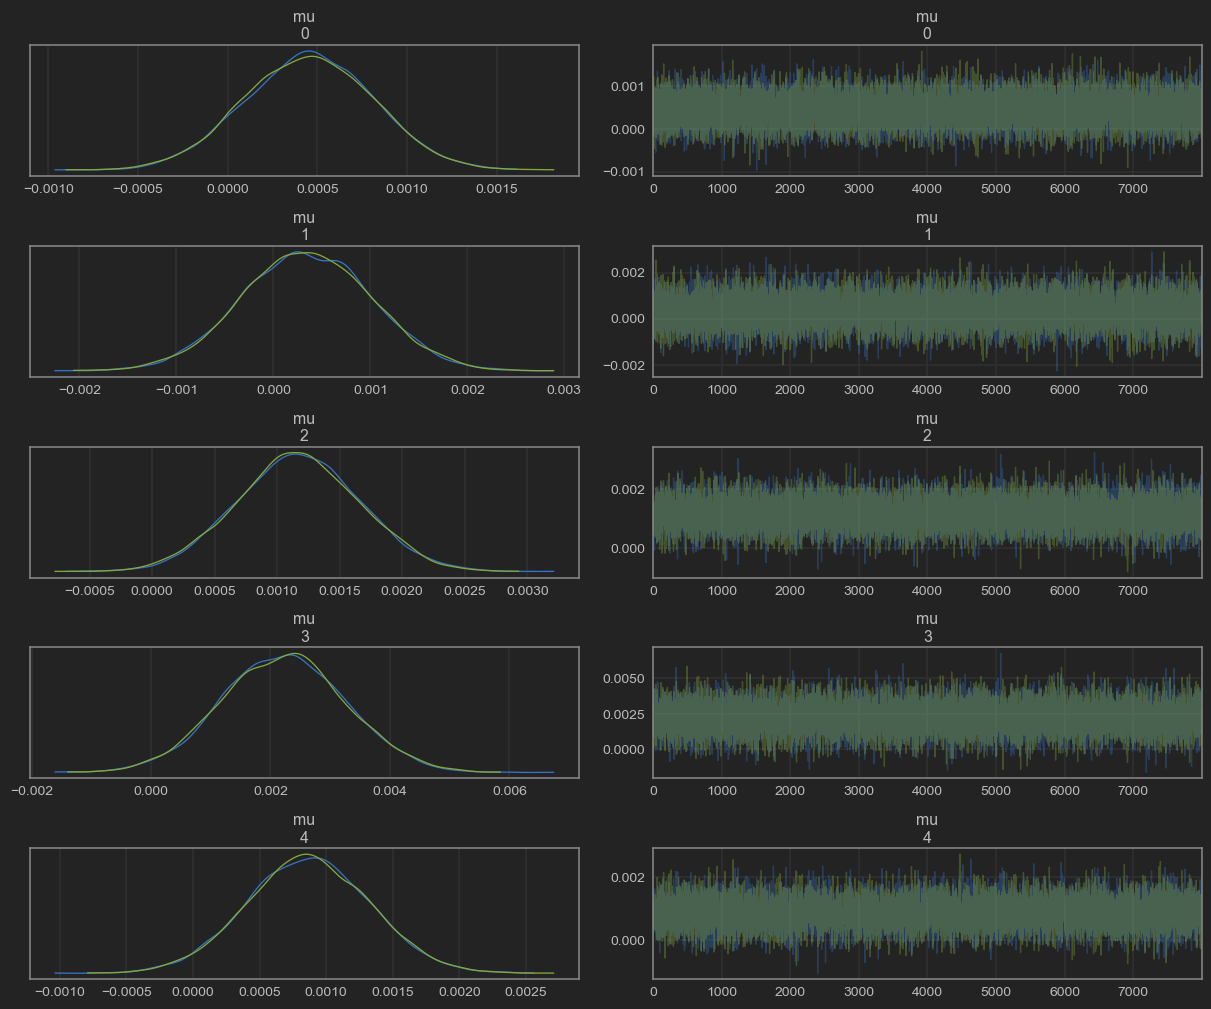

In [19]:
az.plot_trace(trace, var_names=['mu']);
plt.savefig

C:\Users\Jonathan\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\arviz\plots\traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D67A8BF970>,
      dtype=object)

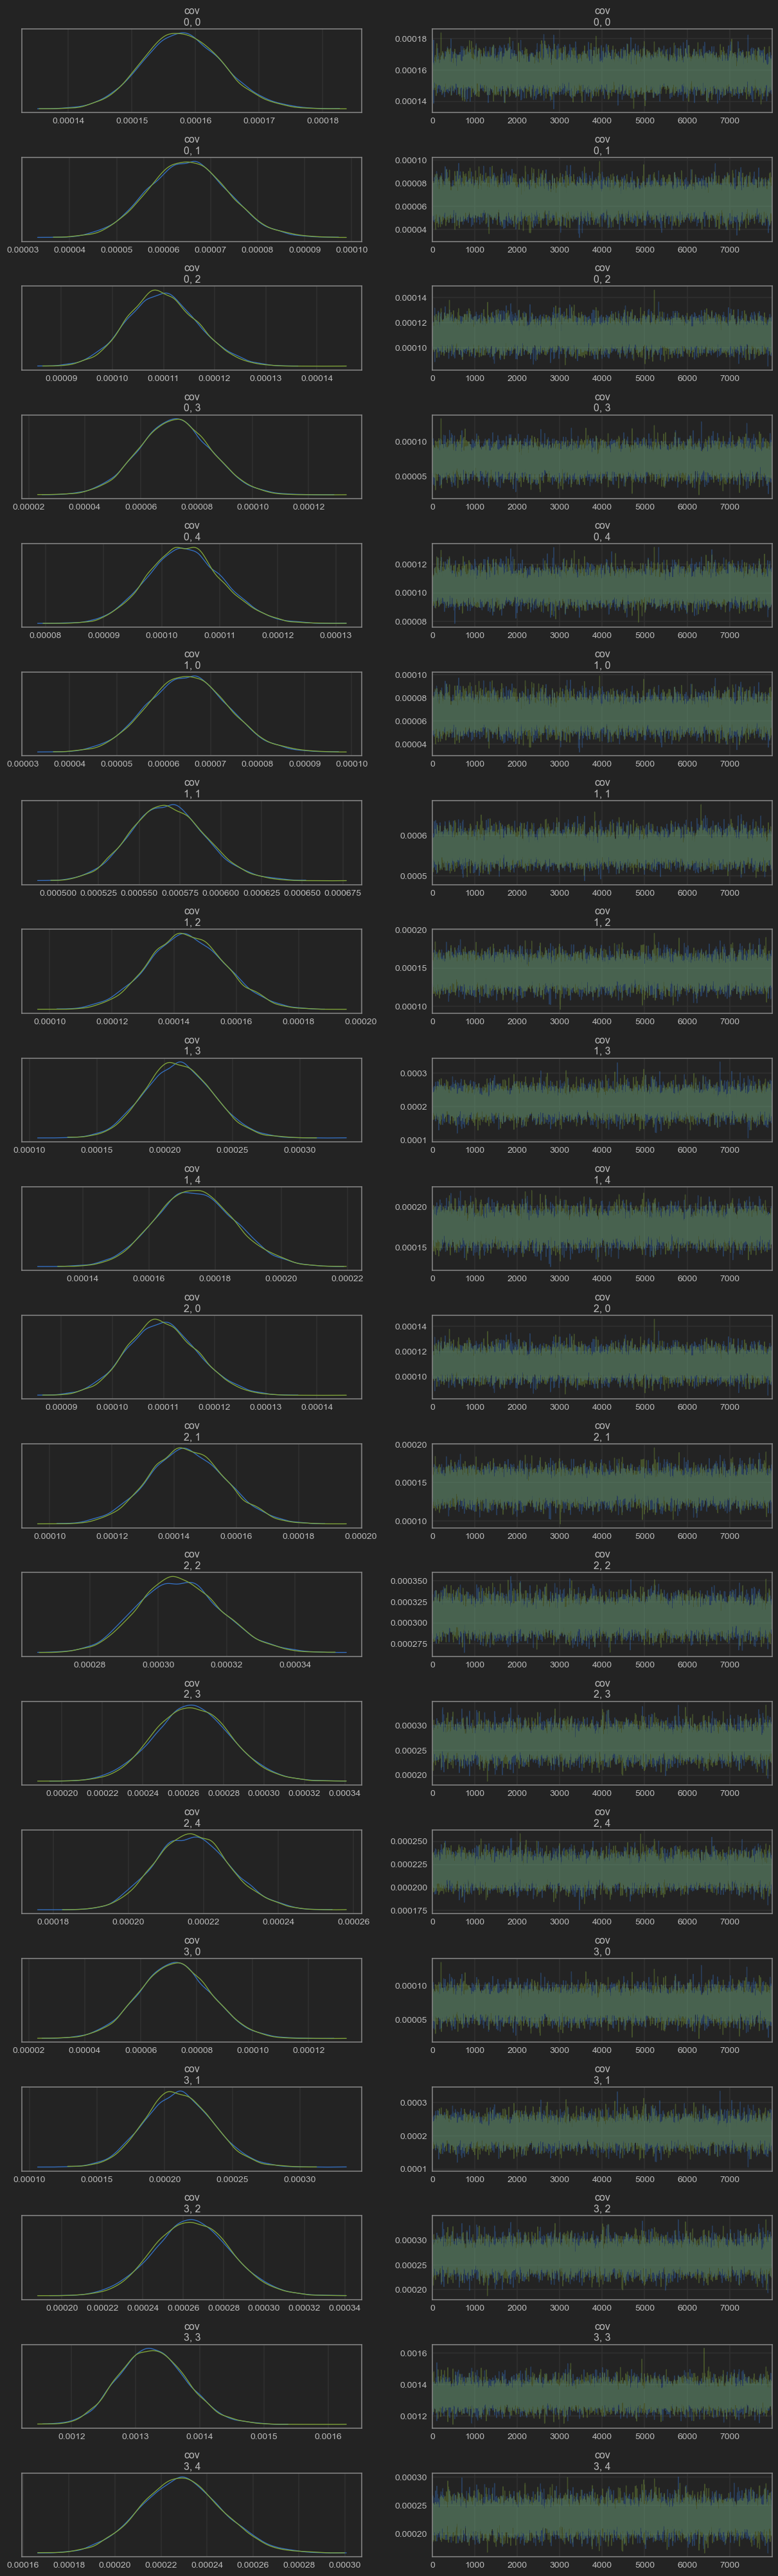

In [27]:
az.plot_trace(trace, var_names=['cov'])

# model_checks.py
Generates some checks for the MCMC sampler.

In [28]:
def load_trace(model):
    trace = pm.load_trace(sys.path[0]+"/sampling_traces/", model=model)
    return trace

In [ ]:
def plot_mu_vec(trace):
    az.plot_trace(trace, var_names=['mu'])
    plt.savefig("mu_traceplot", dpi=250)

In [ ]:
def plot_cov_mat(trace):
    az.plot_trace(trace, var_names=['cov'])
    plt.savefig("cov_traceplot", dpi=250)

# forecasting.py

In [4]:
# Load in the data
os.chdir(sys.path[0])
log_rets = pd.read_csv("log_returns.csv", index_col="Date", parse_dates=True)
data = log_rets.values

In [5]:
def build_model(data):
    with pm.Model() as model:
        ndim = data.shape[1]
        chol, corr, stds = pm.LKJCholeskyCov(
            "chol", n=ndim, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
        )
        chol2 = pm.Deterministic("chol2", chol)
        cov = pm.Deterministic("cov", chol.dot(chol.T))
        mu = pm.Normal("mu", 0.0, 1.0, shape=ndim)
        nu1 = pm.HalfNormal("nu_minus_2", sigma=1)
        nu2 = pm.Deterministic("nu", 2.0+nu1)
        obs = pm.MvStudentT("obs", nu=nu2, mu=mu, chol=chol, observed=data, shape=(1, ndim))
    return model

def load_trace(model):
    trace = pm.load_trace(sys.path[0]+"/sampling_traces/", model=model)
    return trace

In [6]:
model = build_model(data)

In [7]:
trace = load_trace(model)

In [6]:
trace.varnames

['chol_cholesky-cov-packed__',
 'mu',
 'nu_minus_2_log__',
 'chol',
 'chol_stds',
 'chol_corr',
 'chol2',
 'cov',
 'nu_minus_2',
 'nu']

In [15]:
nsamps = trace["nu"].shape[0]
print(nsamps)

4000


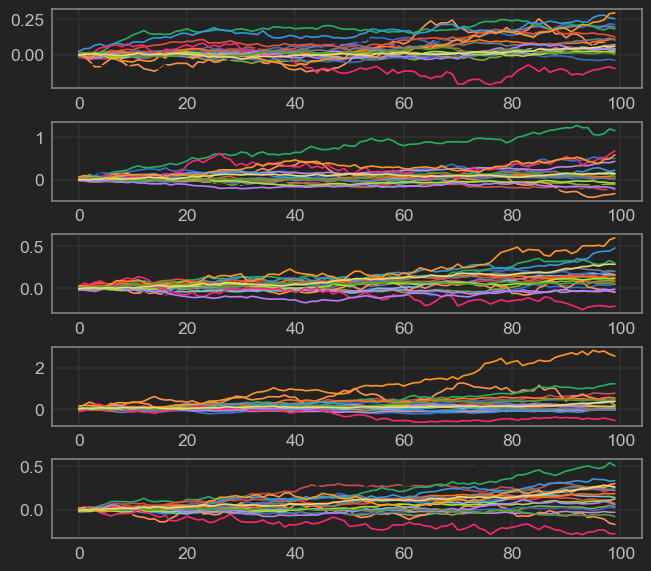

In [293]:
fig, axs = plt.subplots(5,1)

for j in range(20):
    samps = pm.MvStudentT.dist(nu=trace["nu"][-j]*np.ones(1), mu=trace["mu"][-j,:], chol=trace["chol2"][-j,:,:], shape=(100,5)).random(1)
    for i in range(5):
        x1 = (1.0 + samps[0,:,:]).cumprod(axis=0)[:,i] - 1.0
        axs[i].plot(x1)

In [394]:
j = 2
samps = pm.MvStudentT.dist(nu=trace["nu"][-j]*np.ones(1), mu=trace["mu"][-j,:], chol=trace["chol2"][-j,:,:], shape=(100,5)).random(1)

For each sample in the first dim, generate an (ndim x ndays) array. So in total, (nsamps x ndim x ndays)

In [311]:
np.random.multivariate_normal(np.zeros(5), np.ones((5,5)))

array([-0.94650485, -0.94650486, -0.94650486, -0.94650486, -0.94650486])

In [312]:
np.random.multivariate_normal(trace["mu"], trace["chol2"])

ValueError: mean must be 1 dimensional

In [431]:
mus.shape[1]

5

In [8]:
nsamps = trace["nu"].shape[0] # number of MCMC samples

# samples of nu
nus = trace["nu"]

# samples of mu
mus = trace["mu"]

# samples of the chol fact of the cov matrix
chols = trace["chol2"]

In [9]:
# Now, because of shape issues we need some new code to generate multiple samples across the different MCMC samples

# # Generate samples from the standard multivariate normal distribution.
dim = len(mus[0])
samps_per_param = 100 # this can be seen as number of days
zero_means = np.zeros(mus.shape)
u = np.random.multivariate_normal(np.zeros(dim), np.eye(dim),
                                  size=(len(zero_means), samps_per_param,))
# u has shape (len(means), nsamples, dim)

# # Transform u.
v = np.einsum('ijk,ikl->ijl', u, chols)
m = np.expand_dims(zero_means, 1)
t = v + m
# Now t is distributed N(0, Cov) but is 3-dim, which is what we want

# Now we need the normalization constants, which are sqrt(U/nu) where U is chi^2_nu distributed
prefac = np.random.chisquare(nus)
prefac /= nus
prefac = np.sqrt(prefac)

# Now broadcast to the N(0, Cov) samples
offset = t/prefac[:,None,None]

# Now add the true mean
samps = mus[:,None,:] + offset
print(samps.shape)

# Calculate cumulative gains for each algo
cum_returns = (1.0 + samps[:,:,:]).cumprod(axis=1) - 1.0
print(samps.shape)

# Slice out the cumulative gain at the final time
ending_returns = cum_returns[:,-1,:]

(4000, 100, 5)
(4000, 100, 5)


IndexError: Replacement index 3 out of range for positional args tuple

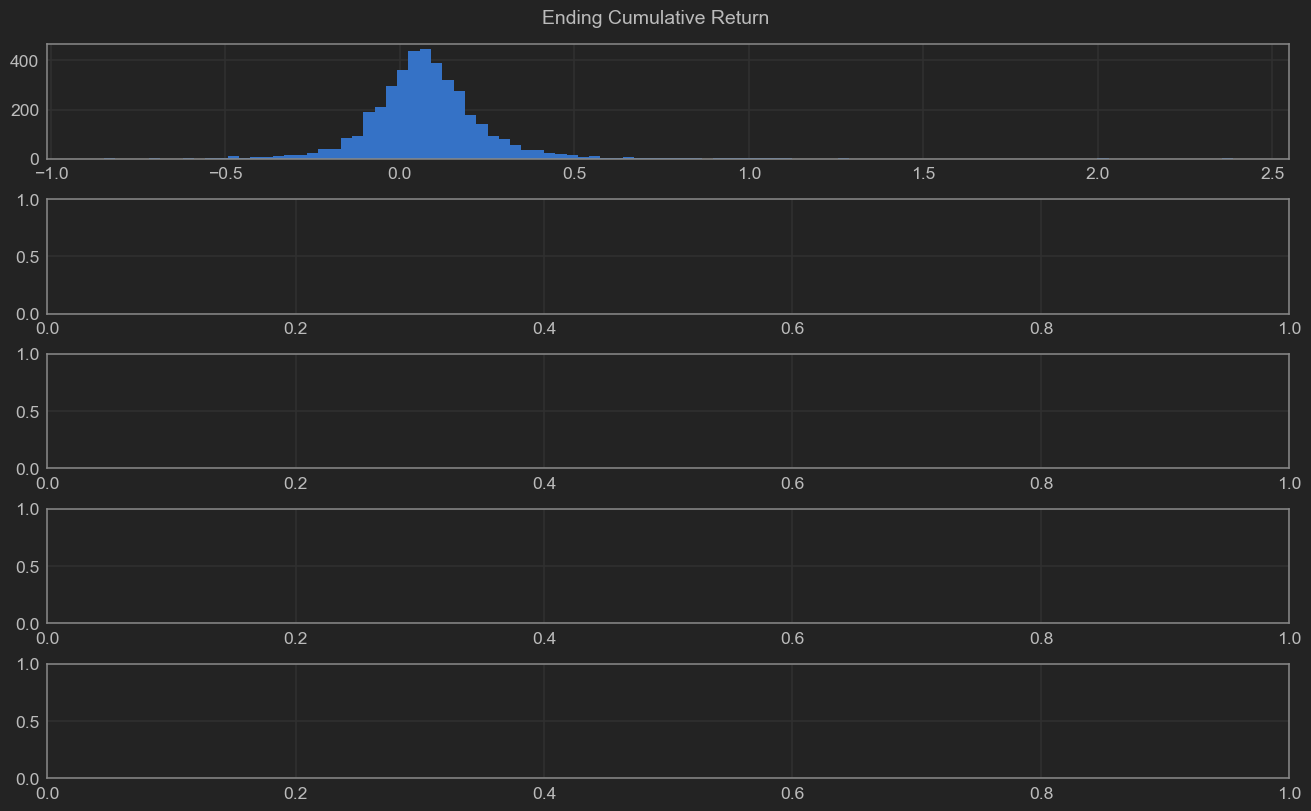

In [9]:
fig, axs = plt.subplots(5,1,figsize=(13,8))
fig.suptitle("Ending Cumulative Return", fontsize=14)
for j in range(5):
    num_entries = len(ending_returns[:,j])
    lower = 100*np.quantile(ending_returns[:,j], 0.05)
    upper = 100*np.quantile(ending_returns[:,j], 0.95)
    num_nonneg = np.sum(ending_returns[:,j] >= 0)
    prob_gain = 100*(num_nonneg/num_entries)
    
    axs[j].hist(ending_returns[:,j], bins=100)
    axs[j].set_xlabel("Algo {}. 95% CI is [{:.1f}%,{:.1f}%]. Prob(gain) = {:1f}%".format(j, lower, upper))
    axs[j].set_ylabel("Freq")

In [444]:
ending_returns.shape

(4000, 5)

In [ ]:
for k in range(1000):
    plt.plot(cum_returns[k, :, 0])

# Loss function

In [9]:
def visualize_loss(lams=[0.1, 0.4, 0.7, 1.0], xmin=-3.0, xmax=3.0, npoints=1000):
    '''
    Helps visualize the loss function.
    '''
    fig, axs = plt.subplots(1, 2, figsize=(13,8))
    
    # subplot 1
    dom = np.linspace(xmin, xmax, npoints)/100
    for lam in lams:
        y = - np.exp(-lam*dom)
        axs[0].plot(dom, y, label="lambda = {}".format(lam))
    axs[0].set_xlabel("Portfolio Return")
    axs[0].set_ylabel("Loss Function Given Portfolio Return")
    axs[0].set_title("Small-scale Loss Function")
    axs[0].legend()
    
    # subplot 2
    dom = np.linspace(xmin, xmax, npoints)
    for lam in lams:
        y = - np.exp(-lam*dom)
        axs[1].plot(dom, y, label="lambda = {}".format(lam))
    axs[1].set_xlabel("Portfolio Return")
    axs[1].set_ylabel("Loss Function Given Portfolio Return")
    axs[1].set_title("Small-scale Loss Function")
    axs[1].legend()
    
    
    #plt.legend()
    fig.show()

<ipython-input-9-0431444ad238>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


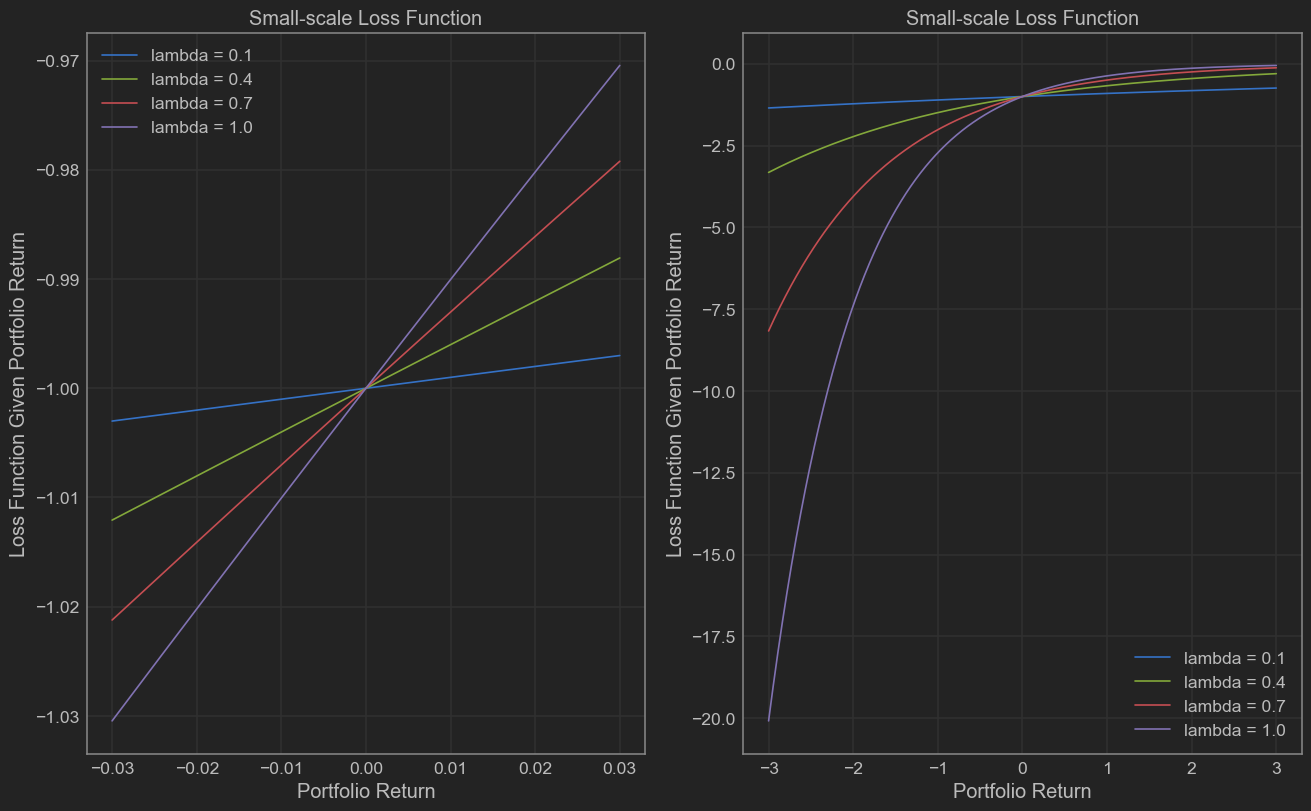

In [10]:
visualize_loss()

In [12]:
def loss(ending_returns, lam=1.0):
    '''
    Evaluates the loss function. You want this to be speedy, since it gets called repeatedly by the optimizer.
    You can in theory throw in whatever kinds of penalizing terms you want.
    
    Here I've implemented the loss function that Thomas Wiecki showed in his Thalesians talk. Lambda controls
    the level of risk aversion. Loss is essentially E[-exp(-lam*r)].
    
    Since we want to use cvxpy to optimize, must formulate in terms of the cvxpy package.
    '''
    import cvxpy as cp
    
    ndim = ending_returns.shape[1]
    w = cp.Variable(ndim)
    loss = cp.sum( -1.0*cp.exp( -lam*( ending_returns @ w ) ) )
    prob = cp.Problem(cp.Maximize(loss), 
                   [cp.sum(w) == 1, 
                    w >= 0])
    prob.solve()
    return w.value
    
    #loss = cp.sum(   cp.log_sum_exp(cp.hstack([np.zeros((m, 1)), -cp.multiply(Y, X @ theta)]), axis=1)    )
    
    #loss = (-1.0*np.exp(-lam*np.matmul(ending_returns, w))).sum()
    #return loss

In [476]:
def find_optimal_weights(loss, ending_returns, lam):
    '''
    Given loss function and inputs, computes the optimal weight vector w.
    '''
    import cvxpy as cp
    
    ndim = ending_returns.shape[1]
    w = cp.Variable(ndim)
    lam_loss = lambda x: loss(x, ending_returns, lam)
    loss_eval = lam_loss(w) 
    prob = cp.Problem(cp.Maximize(loss_eval), 
                   [cp.sum(w) == 1, 
                    w >= 0])
    prob.solve()    
    return w.value

In [13]:
def loss(ending_returns, lam=1.0):
    '''
    Defines the loss optimization problem to solve with cvxpy, and returns the solution.
    '''
    ndim = ending_returns.shape[1]
    w = cp.Variable(ndim)
    loss = cp.sum( -1.0*cp.exp( -lam*( ending_returns @ w ) ) )
    prob = cp.Problem(cp.Maximize(loss), 
                       [cp.sum(w) == 1, 
                        w >= 0])
    prob.solve()
    sol = np.array(w.value)
    return sol

In [ ]:
prob, w = loss(ending_returns)

In [10]:
import cvxpy as cp
    
lam = 1.0
ndim = ending_returns.shape[1]
w = cp.Variable(ndim)
loss = cp.sum( -1.0*cp.exp( -lam*( ending_returns @ w ) ) )
prob = cp.Problem(cp.Maximize(loss), 
                   [cp.sum(w) == 1, 
                    w >= 0])

In [11]:
prob.solve()

-3226.12134306192

In [15]:
w.value

array([-1.47866695e-09, -7.14955242e-10, -1.20210933e-09,  6.95377251e-01,
        3.04622751e-01])

In [16]:
w.value

array([-1.47866695e-09, -7.14955242e-10, -1.20210933e-09,  6.95377251e-01,
        3.04622751e-01])

# analysis.py
tools for analyzing the results of the optimizer

In [18]:
w_opt = w.value.copy()

In [42]:
names = ["Algo{}".format(i) for i in range(ndim)]
weight_dict = dict(zip(names, w_opt))

In [ ]:
names = list(data.keys())
values = list(data.values())

Text(0, 0.5, '% Allocation')

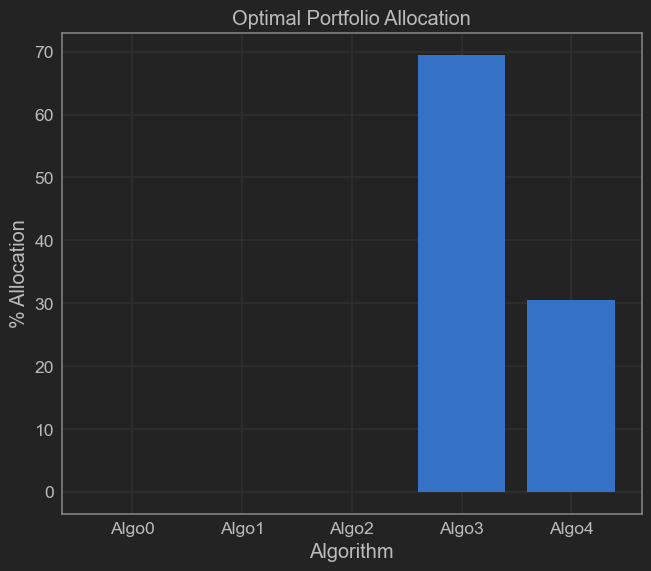

In [47]:
plt.bar(names, 100*w_opt)
plt.title("Optimal Portfolio Allocation")
plt.xlabel("Algorithm")
plt.ylabel("% Allocation")

In [ ]:
names = ["Algo{}".format(i) for i in range(ndim)]
eight_dict = dict(zip(names, sol))

In [21]:
cum_returns.shape

(4000, 100, 5)

In [34]:
cum_ret_shape = cum_returns.shape
ndays = cum_ret_shape[1]
port_ret_samps = np.zeros((cum_ret_shape[0], cum_ret_shape[1]))
for j in range(ndays):
    port_ret_samps[:, j] = np.matmul(cum_returns[:,j,:], w_opt)

In [36]:
ret_samps.shape

(4000, 100)

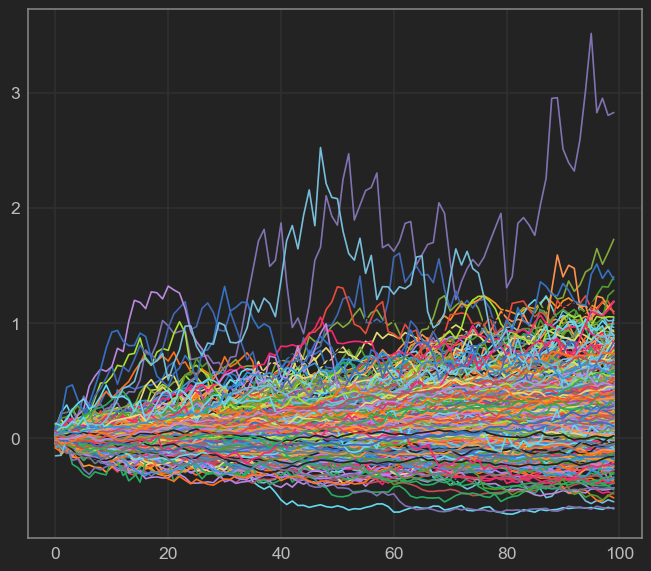

In [40]:
for j in range(1000):
    plt.plot(ret_samps[j,:])

# LKJ Cholesky Covar Example
https://docs.pymc.io/notebooks/LKJ.html

In [8]:
from matplotlib.patches import Ellipse

In [9]:
N = 10000

μ_actual = np.array([1.0, -2.0])
sigmas_actual = np.array([0.7, 1.5])
Rho_actual = np.matrix([[1.0, -0.4], [-0.4, 1.0]])

Σ_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)
Σ_actual

matrix([[ 0.49, -0.42],
        [-0.42,  2.25]])

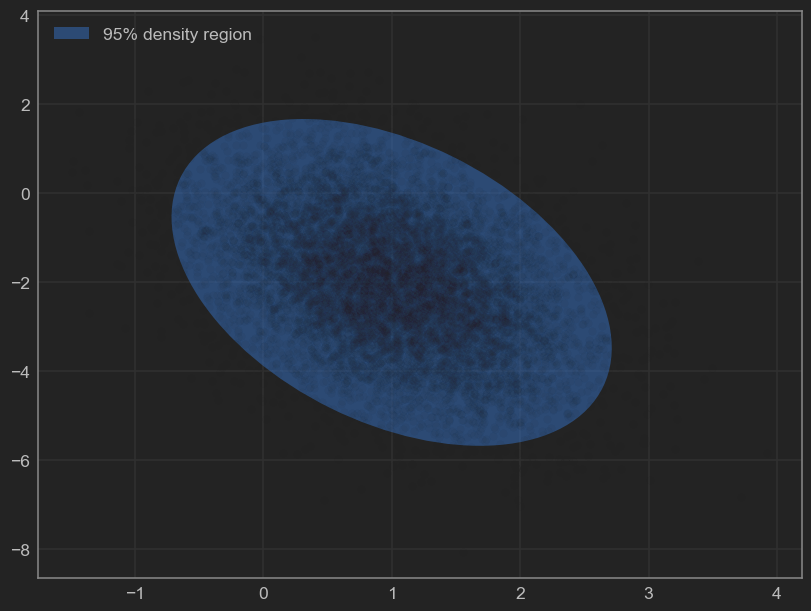

In [18]:
var, U = np.linalg.eig(Σ_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ["95% density region"], loc=2);

In [19]:
with pm.Model() as m:
    packed_L = pm.LKJCholeskyCov("packed_L", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0))

In [20]:
packed_L.tag.test_value.shape

(3,)

In [21]:
L = pm.expand_packed_triangular(2, packed_L)
Σ = L.dot(L.T)

L.tag.test_value.shape

(2, 2)

In [22]:
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))

In [23]:
with model:
    μ = pm.Normal("μ", 0.0, 1.5, shape=2, testval=x.mean(axis=0))
    obs = pm.MvNormal("obs", μ, chol=chol, observed=x)

In [24]:
with model:
    trace = pm.sample(random_seed=RANDOM_SEED, init="adapt_diag", return_inferencedata=True)
az.summary(trace, var_names=["~chol"], round_to=2)

NameError: name 'RANDOM_SEED' is not defined